In [45]:
import numpy as np
import pandas as pd
from scipy.linalg import svd
import matplotlib.pyplot as plt
import seaborn as sns
import time

**Question_1**

In [46]:
col_names=['X', 'Y', 'Z']

In [47]:
def read_conformations():
    data= pd.read_csv('10_conformations.txt', sep='\t', skiprows=2, names=col_names)
    molecule_names= ['mol_{}'.format(i) for i in range(1, 11)]
    for i in range(1, 11):
        start_index= (i-1)*369
        end_index= i*369
        data.loc[start_index:end_index,'mol']= f'Mol_{i}'
    return data 

In [48]:
data=read_conformations()
data.head()

,X,Y,Z,mol
0,2.816,-11.005,10.087,Mol_1
1,4.430,-10.545,10.011,Mol_1
2,3.476,-10.324,9.659,Mol_1
3,3.551,-10.478,8.633,Mol_1
4,3.109,-8.958,10.026,Mol_1


In [49]:
def crmsd(mtrx_1,mtrx_2):
    mtrx_1 -= np.mean(mtrx_1, axis = 0)
    mtrx_2 -= np.mean(mtrx_2, axis = 0)
    temp_mtrx = mtrx_1.T@mtrx_2
    u, s, vT = np.linalg.svd(temp_mtrx, full_matrices=True)
    Q_mtrx = u@vT
    if np.linalg.det(Q_mtrx)<0:
        u[:,-1]*= -1
        Q_mtrx = u@vT
    A_mtrx = mtrx_1@Q_mtrx.T-mtrx_2
    value = np.sqrt(np.sum(pow((np.linalg.norm(A_mtrx)),2)/mtrx_1.shape[0]))
    return value

In [50]:
start_time = time.time()
cRMSD_mtrx=np.zeros(shape=(10,10))
row=0
for base_mol in data.mol.unique():
    subset_base = data.loc[data.mol == base_mol, ['X', 'Y', 'Z']].values
    col=0
    for comp_mol in data.mol.unique():
        if row<col:
            subset_comp = data.loc[data.mol == comp_mol, ['X', 'Y', 'Z']].values
            mtrx_value = crmsd(subset_base,subset_comp)
            cRMSD_mtrx[row, col] = mtrx_value
            cRMSD_mtrx[col, row] = mtrx_value
        elif row == col: cRMSD_mtrx[row,col] = 0
        col+=1
    row+=1              
end_time = time.time()


In [51]:
cRMSD_time= end_time - start_time
cRMSD_time

0.06032538414001465

In [52]:
def df_format(mtrx,names):
    col_means = np.mean(mtrx, axis=0)
    min_col_index = np.argmin(col_means)
    data = pd.DataFrame(mtrx, columns=names)  
    min_col_name = data.columns[min_col_index]

    print(min_col_name)
    return data

In [53]:
df=df_format(cRMSD_mtrx,data.mol.unique())

Mol_4


In [54]:
df.Mol_4.mean()

8.935966389127664

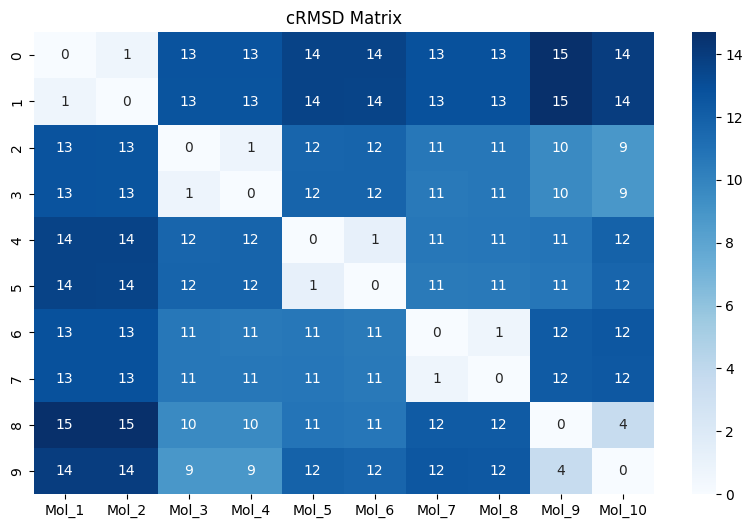

In [55]:
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap='Blues', fmt='.0f')
plt.title('cRMSD Matrix')
plt.show()

**Question_2**

In [56]:
def drmsd(subset):
    dist_mtrx=np.zeros(shape=(subset.shape[0],subset.shape[0]))
    for i in range(subset.shape[0]):
        for j in range(subset.shape[0]):
            if i < j:
                dist_mtrx[i,j]=(np.linalg.norm(subset[i]-subset[j]))
                dist_mtrx[j,i]=(np.linalg.norm(subset[i]-subset[j]))
            elif i==j:
                dist_mtrx[i,j]=0
    return dist_mtrx


In [57]:
start_time = time.time()
dRMSD_mtrx=np.zeros(shape=(10,10))
row=0
for base_mol in data.mol.unique():
    subset_base = data.loc[data.mol == base_mol, ['X', 'Y', 'Z']].values
    col=0
    for comp_mol in data.mol.unique():
        if base_mol!= comp_mol:
            subset_comp = data.loc[data.mol == comp_mol, ['X', 'Y', 'Z']].values
            drmsd_base = drmsd(subset_base)
            drmsd_comp = drmsd(subset_comp)
        if row<col:
                temp=0
                for i in range(drmsd_base.shape[0]):
                    for j in range(drmsd_comp.shape[0]):
                        temp+=np.linalg.norm(drmsd_base[i]-drmsd_comp[j])/2 
                dRMSD_mtrx[row,col]=pow(temp/(subset_comp.shape[0]*(subset_base.shape[0]-1)/2),1/2)
                dRMSD_mtrx[col,row]=pow(temp/(subset_comp.shape[0]*(subset_base.shape[0]-1)/2),1/2)
        elif row==col:     dRMSD_mtrx[row,col]=0
        col+=1
    row+=1
end_time = time.time()


In [58]:
dRMSD_time= end_time- start_time
dRMSD_time

84.52876996994019

In [59]:
df_temp=df_format(dRMSD_mtrx,data.mol.unique())

Mol_7


In [60]:
df_temp.Mol_7.mean()

11.031283337213589

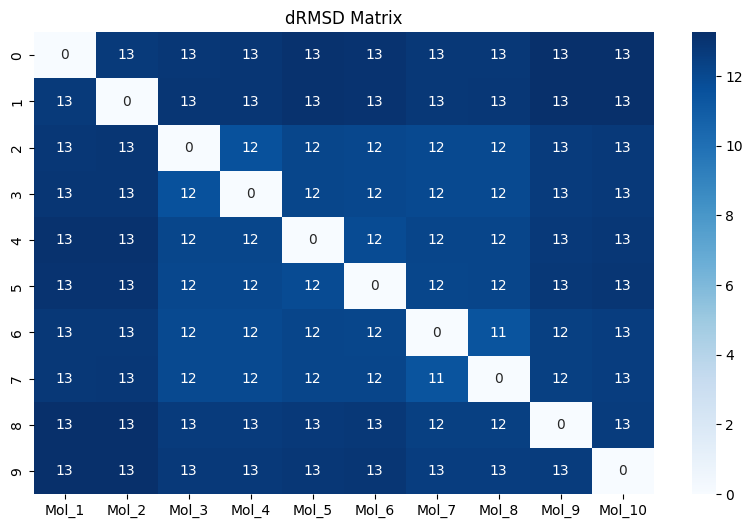

In [61]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_temp, annot=True, cmap='Blues', fmt='.0f')
plt.title('dRMSD Matrix')
plt.show()

**Question_3**

In [62]:
# c-RMSD
col_means = np.mean(cRMSD_mtrx, axis=0)
min_col_index = np.argmin(col_means)
cRMSD_centroid = data.mol.unique()[min_col_index]

# d-RMSD
col_means = np.mean(dRMSD_mtrx, axis=0)
min_col_index = np.argmin(col_means)
dRMSD_centroid = data.mol.unique()[min_col_index]


In [63]:
if cRMSD_centroid == dRMSD_centroid:
    print("The two approaches yield the same centroid.")
else:
    print("The two approaches yield different centroids.")


The two approaches yield different centroids.
